# Markowitz Efficient Frontier for a Crypto Portfolio

This notebook analyzes a portfolio of major crypto assets using Modern Portfolio Theory (MPT). 
The objective is to compute and visualize the Efficient Frontier, identify the maximum Sharpe Ratio portfolio, and understand the return–risk profile of randomly generated portfolios.

The implementation follows a strict modular design:

- All financial logic is contained in `src/optimization.py`
- The notebook is used exclusively for analysis, visualization, and interpretation


In [1]:
import sys
sys.path.append("../")

from src.optimization import (
    default_config,
    load_price_data,
    compute_returns,
    compute_statistics,
    generate_random_portfolios,
    efficient_frontier,
    max_sharpe_ratio,
)

import matplotlib.pyplot as plt
import numpy as np



## 1. Mathematical Background

Modern Portfolio Theory (Markowitz, 1952) models the expected return and risk of a portfolio as:

### Expected Return
If \( w \in \mathbb{R}^n \) is the vector of portfolio weights and \( \mu \in \mathbb{R}^n \) is the vector of annualized expected returns:

\[
\mathbb{E}[R_p] = w^\top \mu
\]

### Portfolio Variance
Given covariance matrix \( \Sigma \in \mathbb{R}^{n \times n} \):

\[
\sigma_p^2 = w^\top \Sigma w
\]

### Sharpe Ratio
With risk-free rate \( r_f \):

\[
\text{Sharpe}(w) = \frac{w^\top \mu - r_f}{\sqrt{w^\top \Sigma w}}
\]

The Efficient Frontier is the set of portfolios with minimum variance for a given expected return.

In this notebook, the frontier is approximated using a Monte Carlo simulation of random portfolios.


In [2]:
prices = load_price_data(default_config)
prices.head()


[*********************100%***********************]  6 of 6 completed


Ticker,ADA-USD,AVAX-USD,BNB-USD,BTC-USD,ETH-USD,SOL-USD
Date,,,,,,
2021-01-01,0.175350,3.664823,37.905010,29374.152344,730.367554,1.842084
2021-01-02,0.177423,3.494940,38.241592,32127.267578,774.534973,1.799275
2021-01-03,0.204995,3.472944,41.148979,32782.023438,975.507690,2.161752
2021-01-04,0.224762,3.590243,40.926353,31971.914062,1040.233032,2.485097
2021-01-05,0.258314,4.237412,41.734600,33992.429688,1100.006104,2.157217


## 2. Data Retrieval

We retrieve daily adjusted closing prices for the selected crypto assets using the Yahoo Finance API (`yfinance`).  
Crypto trades continuously (24/7), therefore returns and covariances are annualized using:

\[
T = 365
\]

Raw price data is transformed into log returns:

\[
r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
\]

Log returns are preferred for crypto due to high volatility and multiplicative compounding behavior.


In [3]:
returns = compute_returns(prices)
mean_returns, covariance = compute_statistics(returns, default_config)

mean_returns, covariance


(Ticker
 ADA-USD     0.407185
 AVAX-USD    0.785065
 BNB-USD     0.703748
 BTC-USD     0.121394
 ETH-USD     0.380023
 SOL-USD     1.337628
 dtype: float64,
 Ticker     ADA-USD  AVAX-USD   BNB-USD   BTC-USD   ETH-USD   SOL-USD
 Ticker                                                              
 ADA-USD   0.976138  0.871207  0.564831  0.426373  0.579853  0.715923
 AVAX-USD  0.871207  1.703045  0.735648  0.500818  0.681389  0.993760
 BNB-USD   0.564831  0.735648  0.902402  0.408829  0.550699  0.709399
 BTC-USD   0.426373  0.500818  0.408829  0.416458  0.447937  0.478126
 ETH-USD   0.579853  0.681389  0.550699  0.447937  0.711285  0.697514
 SOL-USD   0.715923  0.993760  0.709399  0.478126  0.697514  1.684749)

## 3. Monte Carlo Portfolio Generation

To approximate the Efficient Frontier, we generate \( N = 15{,}000 \) random portfolios.

For each portfolio:

1. Draw random weights \( w_i \sim U(0,1) \)
2. Normalize:  
\[
w \leftarrow \frac{w}{\sum_i w_i}
\]
3. Compute expected return  
\[
\mu_p = w^\top \mu
\]
4. Compute volatility  
\[
\sigma_p = \sqrt{w^\top \Sigma w}
\]
5. Compute Sharpe ratio  
\[
S_p = \frac{\mu_p - r_f}{\sigma_p}
\]

This produces a cloud of portfolios.  
The upper boundary of this cloud approximates the Markowitz Efficient Frontier.


In [4]:
results, weights = generate_random_portfolios(mean_returns, covariance, default_config)
results.shape


(3, 15000)

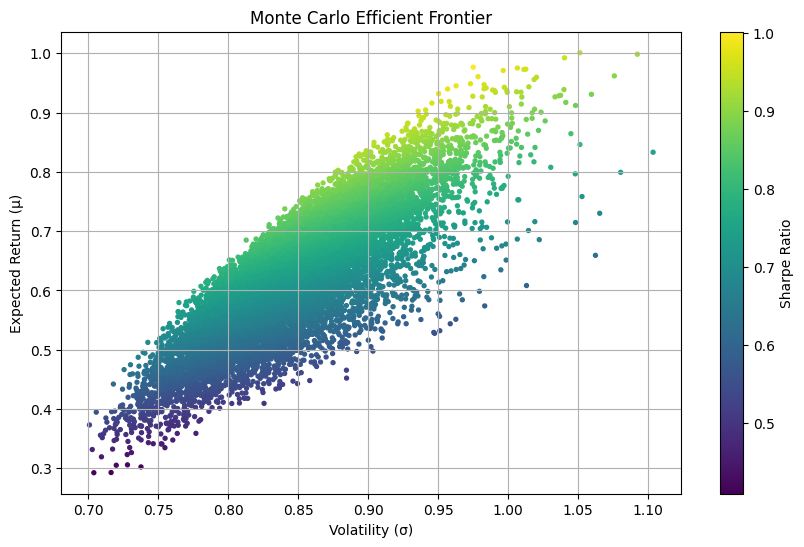

In [5]:
vols = results[0]
rets = results[1]
sharpes = results[2]

plt.figure(figsize=(10, 6))
plt.scatter(vols, rets, c=sharpes, cmap="viridis", s=8)
plt.colorbar(label="Sharpe Ratio")

plt.xlabel("Volatility (σ)")
plt.ylabel("Expected Return (μ)")
plt.title("Monte Carlo Efficient Frontier")
plt.grid(True)
plt.show()


In [6]:
plt.savefig("../data/plots/monte_carlo_frontier.png", dpi=300)


<Figure size 640x480 with 0 Axes>

In [7]:
ef_vols, ef_rets, ef_weights = efficient_frontier(
    mean_returns,
    covariance,
    default_config,
    points=50
)


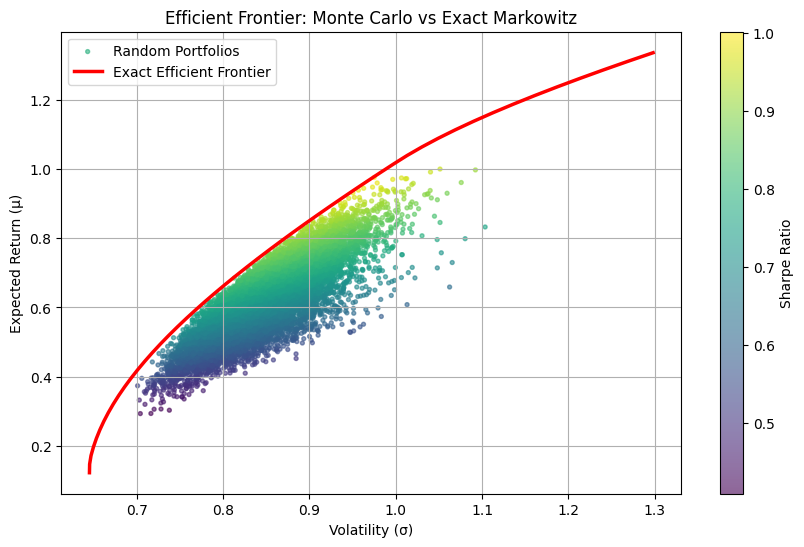

In [8]:
plt.figure(figsize=(10, 6))

# Monte Carlo cloud
plt.scatter(vols, rets, c=sharpes, cmap="viridis", s=8, alpha=0.6, label="Random Portfolios")

# Exact frontier curve
plt.plot(ef_vols, ef_rets, "r-", linewidth=2.5, label="Exact Efficient Frontier")

plt.xlabel("Volatility (σ)")
plt.ylabel("Expected Return (μ)")
plt.title("Efficient Frontier: Monte Carlo vs Exact Markowitz")
plt.colorbar(label="Sharpe Ratio")
plt.grid(True)
plt.legend()
plt.show()


In [9]:
plt.savefig("../data/plots/exact_efficient_frontier.png", dpi=300)


<Figure size 640x480 with 0 Axes>

In [10]:
w_star, ret_star, vol_star, sharpe_star = max_sharpe_ratio(
    mean_returns,
    covariance,
    default_config
)

w_star, ret_star, vol_star, sharpe_star


(array([2.55188626e-17, 0.00000000e+00, 2.50662431e-01, 1.44600005e-17,
        0.00000000e+00, 7.49337569e-01]),
 1.178737882649112,
 1.1265838167179367,
 1.046293995313296)

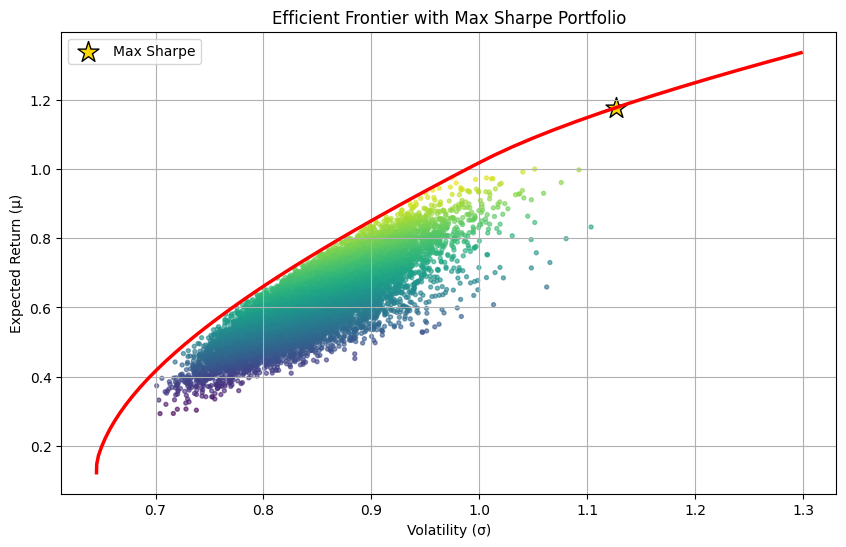

In [11]:
plt.figure(figsize=(10, 6))

plt.scatter(vols, rets, c=sharpes, cmap="viridis", s=8, alpha=0.6)
plt.plot(ef_vols, ef_rets, "r-", linewidth=2.5)

# Mark max Sharpe point
plt.scatter(vol_star, ret_star, marker="*", s=250, color="gold", edgecolor="black", label="Max Sharpe")

plt.xlabel("Volatility (σ)")
plt.ylabel("Expected Return (μ)")
plt.title("Efficient Frontier with Max Sharpe Portfolio")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
plt.savefig("../data/plots/frontier_with_max_sharpe.png", dpi=300)


<Figure size 640x480 with 0 Axes>

## 4. Interpretation of Results

The scatter plot visualizes the risk–return space of 15,000 random portfolios:

- **X-axis:** Portfolio volatility \( \sigma_p \)
- **Y-axis:** Expected annual return \( \mu_p \)
- **Color:** Sharpe Ratio (risk-adjusted performance)

The Efficient Frontier emerges as the upper boundary of the plotted points.  
Portfolios below the frontier are inefficient because a combination with identical risk but higher return exists.

We also identify the **Maximum Sharpe Ratio Portfolio**, which maximizes:

\[
\frac{w^\top \mu - r_f}{\sqrt{w^\top \Sigma w}}
\]

This portfolio represents the optimal risk-adjusted allocation within the given universe of crypto assets.


## 5. Exact Efficient Frontier (Markowitz Optimization)

The Monte Carlo cloud provides an approximation, but the exact frontier is obtained by solving the quadratic optimization problem:

\[
\min_w \quad w^\top \Sigma w
\]
subject to:
\[
w^\top \mu = \mu^*, \quad \sum_i w_i = 1, \quad w_i \in [0,1]
\]

This generates the smooth red curve representing the true minimum-variance portfolios for each target return.


## 6. Tangency Portfolio (Maximum Sharpe Ratio)

The optimal portfolio under Modern Portfolio Theory is the portfolio with the maximum Sharpe Ratio:

\[
\max_w \; \frac{w^\top \mu - r_f}{\sqrt{w^\top \Sigma w}}
\]

This portfolio lies at the tangent point between the risk-free rate line and the efficient frontier.
It is the unique portfolio that offers the highest risk-adjusted return.


In [13]:
max_sharpe_idx = np.argmax(sharpes)
best_weights = weights[max_sharpe_idx]

best_weights, sharpes[max_sharpe_idx]


(array([0.00979896, 0.00819826, 0.4512977 , 0.01808342, 0.04126093,
        0.47136073]),
 np.float64(1.0013955261198986))

## 7. Conclusion

This analysis demonstrates the application of Modern Portfolio Theory to a multi-asset crypto portfolio. 
Despite the high volatility and non-normal return characteristics of cryptocurrencies, the Markowitz framework provides:

- A structured view of the risk–return trade-off  
- Optimal portfolio configurations under quadratic optimization  
- A quantitative foundation for future enhancements

Further improvements will include:
- Exact convex optimization using quadratic programming (QP)
- Constraints (min/max weights)
- Regularization to reduce instability
- Robust covariance estimation (Ledoit–Wolf shrinkage)
- Out-of-sample backtesting

This notebook serves as the baseline for a complete portfolio optimization pipeline.
